# Explore erasure decoding using stim

Until Feb 5th 2025, I haven't found any publicly available decoder that is capable of doing erasure decoding directly using the `HERALDED_*` instructions in a stim circuit.
I think the complication comes from the fact that one would have to analyze the circuit and recognize those instructions.
Let me first play with these instructions first and see whether this is a not-so-complicated task.

Here is a link posted on Dec 25th 2024 asking for decoder support of erasure errors [https://quantumcomputing.stackexchange.com/questions/26582/how-do-i-perform-an-erasure-error-in-stim](https://quantumcomputing.stackexchange.com/questions/26582/how-do-i-perform-an-erasure-error-in-stim).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import stim

In [3]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

circuit.append("HERALDED_ERASE", [0], [0.25])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

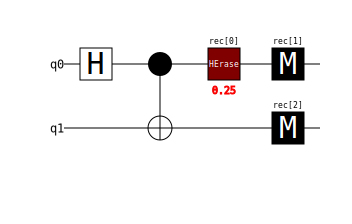

In [4]:
circuit.diagram('timeline-svg')

In [5]:
circuit.detector_error_model(approximate_disjoint_errors=True)

stim.DetectorErrorModel()

In [6]:
import arguably
import sinter
from typing import Optional
from sinter._decoding import sample_decode

from qec_lego_bench.cli.util import *
from qec_lego_bench.cli.codes import *
from qec_lego_bench.cli.noises import *
from qec_lego_bench.cli.decoders import *
from qec_lego_bench.stats import Stats

In [7]:
code_instance = CodeCli("rep(d=3,rounds=1,p=0.001)")()
circuit = code_instance.circuit

In [8]:
circuit

stim.Circuit('''
    R 0 1 2 3 4
    X_ERROR(0.001) 0 1 2 3 4
    TICK
    DEPOLARIZE1(0.001) 0 2 4
    CX 0 1 2 3
    DEPOLARIZE2(0.001) 0 1 2 3
    TICK
    CX 2 1 4 3
    DEPOLARIZE2(0.001) 2 1 4 3
    TICK
    X_ERROR(0.001) 1 3
    MR 1 3
    X_ERROR(0.001) 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    X_ERROR(0.001) 0 2 4
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')

In [9]:
circuit = stim.Circuit('''
    R 0 1 2 3 4
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    HERALDED_ERASE(0.01) 0
    DETECTOR rec[-1]
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-6]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-5]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')
circuit.detector_error_model(approximate_disjoint_errors=True)

stim.DetectorErrorModel('''
    error(0.005) D2
    error(0.005) D2 D3
    detector(1, 0) D0
    detector(3, 0) D1
    detector(1, 1) D3
    detector(3, 1) D4
    logical_observable L0
''')

In [10]:
circuit.compile_detector_sampler()

stim.CompiledDetectorSampler(stim.Circuit('''
    R 0 1 2 3 4
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    HERALDED_ERASE(0.01) 0
    DETECTOR rec[-1]
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-6]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-5]
    OBSERVABLE_INCLUDE(0) rec[-1]
'''))

In [11]:
dem = circuit.detector_error_model(approximate_disjoint_errors=True)
dem

stim.DetectorErrorModel('''
    error(0.005) D2
    error(0.005) D2 D3
    detector(1, 0) D0
    detector(3, 0) D1
    detector(1, 1) D3
    detector(3, 1) D4
    logical_observable L0
''')

In [12]:
list(dem)

[stim.DemInstruction('error', [0.005], [stim.target_relative_detector_id(2)]),
 stim.DemInstruction('error', [0.005], [stim.target_relative_detector_id(2), stim.target_relative_detector_id(3)]),
 stim.DemInstruction('detector', [1, 0], [stim.target_relative_detector_id(0)]),
 stim.DemInstruction('detector', [3, 0], [stim.target_relative_detector_id(1)]),
 stim.DemInstruction('detector', [1, 1], [stim.target_relative_detector_id(3)]),
 stim.DemInstruction('detector', [3, 1], [stim.target_relative_detector_id(4)]),
 stim.DemInstruction('logical_observable', [], [stim.target_logical_observable_id(0)])]

## OK We need to manually support it

The DEM returned from the heralded errors treat them as pure pauli error (even after adding the detection events).
This makes sense because DEM doesn't have native mechanism to describe "conditional" error.
Since `sinter.Decoder` class does not receive the original circuit as input, we will have to do some hacky way by passing the circuit to the decoder outside of the loop.

So the idea is here:

### Adding heralded errors to an existing circuit

When we add Pauli noises, it was very straightforward because we can simply put them into the circuit.
The added errors will not change the indices of any measurements or detectors.
This is no longer true when we add heralded errors.
A heralded error generates one measurement per qubit index.
Thus, all the detector references involving relative indices must have an offset accordingly.
The offset is not a constant value and changes depending on the original index.

### Decoding a circuit with heralded errors

Since the DEM doesn't contain heralded errors, the decoder need to know the information from the circuit.
It will need to analyze what are the 

### Easiest circuit to start with:

```sh
R 0 1 2 3 4
TICK
CX 0 1 2 3
TICK
CX 2 1 4 3
TICK
MR 1 3
DETECTOR(1, 0) rec[-2]
DETECTOR(3, 0) rec[-1]
HERALDED_ERASE(0.01) 0
DETECTOR rec[-1]
M 0 2 4
DETECTOR(1, 1) rec[-2] rec[-3] rec[-6]
DETECTOR(3, 1) rec[-1] rec[-2] rec[-5]
OBSERVABLE_INCLUDE(0) rec[-1]
```

In [55]:
circuit = stim.Circuit('''
    R 0
    HERALDED_ERASE(0.01) 0
    M 0
    OBSERVABLE_INCLUDE(0) rec[-1]
''')
print(f"num_detectors: {circuit.num_detectors}, num_measurements: {circuit.num_measurements}, num_observables: {circuit.num_observables}, num_qubits: {circuit.num_qubits}")
circuit.detector_error_model(approximate_disjoint_errors=True)
# dir(circuit.num_detectors)

num_detectors: 0, num_measurements: 2, num_observables: 1, num_qubits: 1


stim.DetectorErrorModel('''
    error(0.005) L0
''')

In [56]:
## first flatten the operations such that 
operations = circuit.flattened_operations()
operations

[('R', [0], 0),
 ('HERALDED_ERASE', [0], 0.01),
 ('M', [0], 0),
 ('OBSERVABLE_INCLUDE', [('rec', -1)], 0.0)]

In [50]:
stim.target_rec(-2)

stim.target_rec(-2)

In [51]:
circuit = stim.Circuit()
circuit.append('R', [0], 0)
circuit.append('HERALDED_ERASE', [0], 0.01)
circuit.append('M', [0], 0)
circuit.append('OBSERVABLE_INCLUDE', [('rec', -1)], 0.0)
circuit

ValueError: Gate R was given 1 parens arguments (0) but takes 0 parens arguments.

In [60]:
circuit

stim.Circuit('''
    R 0
    HERALDED_ERASE(0.01) 0
    M 0
    OBSERVABLE_INCLUDE(0) rec[-1]
''')

In [86]:
circuit2 = stim.Circuit()
for operation in circuit:
    print(operation, "****", operation.name, operation.gate_args_copy(), operation.targets_copy(), operation.tag)  # operation.num_measurements
    circuit2.append(operation.name, arg=operation.gate_args_copy(), targets=operation.targets_copy(), tag="abc")

R 0 **** R [] [stim.GateTarget(0)] 
HERALDED_ERASE(0.01) 0 **** HERALDED_ERASE [0.01] [stim.GateTarget(0)] 
M 0 **** M [] [stim.GateTarget(0)] 
OBSERVABLE_INCLUDE(0) rec[-1] **** OBSERVABLE_INCLUDE [0.0] [stim.target_rec(-1)] 


In [87]:
circuit2

stim.Circuit('''
    R[abc] 0
    HERALDED_ERASE[abc](0.01) 0
    M[abc] 0
    OBSERVABLE_INCLUDE[abc](0) rec[-1]
''')